## Setup

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

In [ ]:
! pip install qkeras==0.9.0
! pip install hls4ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152 kB 12.7 MB/s 
     |████████████████████████████████| 135 kB 55.8 MB/s 
     |████████████████████████████████| 238 kB 61.3 MB/s 
     |████████████████████████████████| 1.6 MB 64.6 MB/s 
  Created wheel for pyparser: filename=pyparser-1.0-py3-none-any.whl size=4942 sha256=94bd8b65817bec5f570daece4078cfa9ce74e3443a52c2d2ec1a1ae6f8f6b54f
  Stored in directory: /root/.cache/pip/wheels/84/80/fe/49e0cb63aba370d3ef38e733a2266c90a4d837921664320003
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18175 sha256=88dc3b4e2edcf251d6c21a1f4573641c7210e76ac98f1b54fa89396df3bd1a9a
  Stored in directory: /root/.cache/pip/wheels/d3/d2/3e/3df86c4fd6ebac1348fbbda0a551e28cacf7301969935732dd
Successfully built pyparser parse
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████████

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pengju26","key":"f68cf84e47d100be88bc6f44ed6d59d2"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
"""
Download the higgs boson data and unzip them
"""
! kaggle competitions download -c higgs-boson 
! unzip higgs-boson.zip -d higgs-boson
! unzip ./higgs-boson/training.zip -d ./higgs-boson/training/

 61% 33.0M/54.3M [00:00<00:00, 109MB/s] 
100% 54.3M/54.3M [00:00<00:00, 136MB/s]
Archive:  higgs-boson.zip
  inflating: higgs-boson/HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: higgs-boson/random_submission.zip  
  inflating: higgs-boson/test.zip    
  inflating: higgs-boson/training.zip  
Archive:  ./higgs-boson/training.zip
  inflating: ./higgs-boson/training/training.csv  


In [ ]:
"""
Checking if everything went well
"""
! ls ./higgs-boson/
! ls ./higgs-boson/training

HiggsBosonCompetition_AMSMetric_rev1.py  test.zip  training.zip
random_submission.zip			 training
training.csv


## Preprocessing

In [ ]:
"""
read the training csvs
"""
import pandas as pd
import numpy as np

df = pd.read_csv("./higgs-boson/training/training.csv")
print(df.head()) 
df = df.drop(columns=['EventId', 'Weight']) 

   EventId  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0   100000       138.470                       51.655        97.827    27.980   
1   100001       160.937                       68.768       103.235    48.146   
2   100002      -999.000                      162.172       125.953    35.635   
3   100003       143.905                       81.417        80.943     0.414   
4   100004       175.864                       16.915       134.805    16.405   

   DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
0                  0.91           124.711                2.666   
1               -999.00          -999.000             -999.000   
2               -999.00          -999.000             -999.000   
3               -999.00          -999.000             -999.000   
4               -999.00          -999.000             -999.000   

   DER_deltar_tau_lep  DER_pt_tot  ...  PRI_jet_num  PRI_jet_leading_pt  \
0               3.064      41.928  ...   

In [ ]:
"""
filter out bad values
"""
df = df.replace(-999.000, np.nan)
df = df.dropna()
print(df.head())

    DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0        138.470                       51.655        97.827    27.980   
5         89.744                       13.550        59.149   116.344   
6        148.754                       28.862       107.782   106.130   
11       114.744                       10.286        75.712    30.816   
23       141.481                        0.736       111.581   174.075   

    DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
0                  0.910           124.711                2.666   
5                  2.636           284.584               -0.540   
6                  0.733           158.359                0.113   
11                 2.563           252.599               -1.401   
23                 1.955           364.344               -0.923   

    DER_deltar_tau_lep  DER_pt_tot  DER_sum_pt  ...  PRI_met_sumet  \
0                3.064      41.928     197.760  ...        258.733   
5                1

In [ ]:
"""
get rid of EventId column. Label column is y (output). Rest is X (input)
"""
X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy() # just get Label
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"Y values b4: {Y}")
# turn the signal and background to 1 and 0 respectively
Y[Y == "s"] = 1
Y[Y == "b"] = 0
print(np.any(Y == "s") or np.any(Y == "b")) # check if there's any non number left
print(f"Y values after: {Y}")
Y = Y.astype('int32').reshape((-1,1))

X shape: (68114, 30)
Y shape: (68114,)
Y values b4: ['s' 'b' 's' ... 's' 's' 'b']
False
Y values after: [1 0 1 ... 1 1 0]


In [ ]:
"""
train test split.
"""
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (54491, 30)
X_test shape: (13623, 30)
Y_train shape: (54491, 1)
Y_test shape: (13623, 1)


## Model Definition and training + testing

In [ ]:
"""
Defining the DNN
use qkeras for quantization, import a model
made in the DNN demoin keras/tensforflow
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.nn as nn

input_dim = X_train.shape[-1]
hidden_dim = 100
n_hidden_layers = 3

model = Sequential()
model.add(BatchNormalization(input_shape=(input_dim,), name='norm'))
model.add(Dense(hidden_dim, name='input_layer', kernel_regularizer=l2(0.0001)))

for idx in range(n_hidden_layers): # hidden layers
    model.add(Activation(activation="relu", name=f'activation_{idx}'))
    model.add(Dense(hidden_dim, name=f'fc{idx}', kernel_regularizer=l2(0.0001)))

model.add(Activation(activation="relu", name=f'activation_output'))
model.add(Dense(1, name='output', kernel_regularizer=l2(0.0001)))
model.add(Activation(activation='sigmoid', name='sigmoid'))

In [ ]:
"""
Training
"""

adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss=['binary_crossentropy'])
model.fit(X_train, Y_train, batch_size=64,
            epochs=30, validation_split=0.20, shuffle=True,
) # fit makes batchnorm to be in training mode


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


682/682 [==============================] - 3s 3ms/step - loss: 0.4558 - val_loss: 0.4115
Epoch 2/30
682/682 [==============================] - 2s 2ms/step - loss: 0.4115 - val_loss: 0.4295
Epoch 3/30
682/682 [==============================] - 2s 3ms/step - loss: 0.4037 - val_loss: 0.3939
Epoch 4/30
682/682 [==============================] - 2s 3ms/step - loss: 0.3956 - val_loss: 0.3912
Epoch 5/30
682/682 [==============================] - 2s 2ms/step - loss: 0.3907 - val_loss: 0.3867
Epoch 6/30
682/682 [==============================] - 2s 3ms/step - loss: 0.3823 - val_loss: 0.3839
Epoch 7/30
682/682 [==============================] - 2s 2ms/step - loss: 0.3820 - val_loss: 0.3822
Epoch 8/30
682/682 [==============================] - 2s 3ms/step - loss: 0.3792 - val_loss: 0.3769
Epoch 9/30
682/682 [==============================] - 2s 2ms/step - loss: 0.3791 - val_loss: 0.3802
Epoch 10/30
682/682 [==============================] - 2s 3ms/step - loss: 0.3727 - val_loss: 0.3766
Epoch 11/3

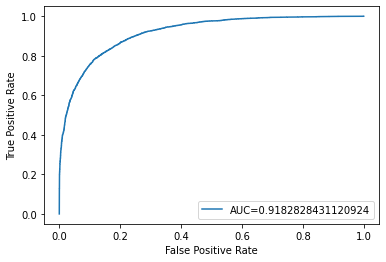

In [ ]:
"""
Testing phase
"""
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(Y_test,  model.predict(X_test, verbose=0))
auc = metrics.roc_auc_score(Y_test, model.predict(X_test, verbose=0))
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## HLS4ML Conversion

Convert the python model into one that's ready for a conversion to HLS code usinig hls4ml.

hls4ml related code based on https://github.com/fastmachinelearning/hls4ml-tutorial.

In [ ]:

import hls4ml
config = hls4ml.utils.config_from_keras_model(model,
                                     default_precision="ap_fixed<32,12>",
                                     granularity='model'
)
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

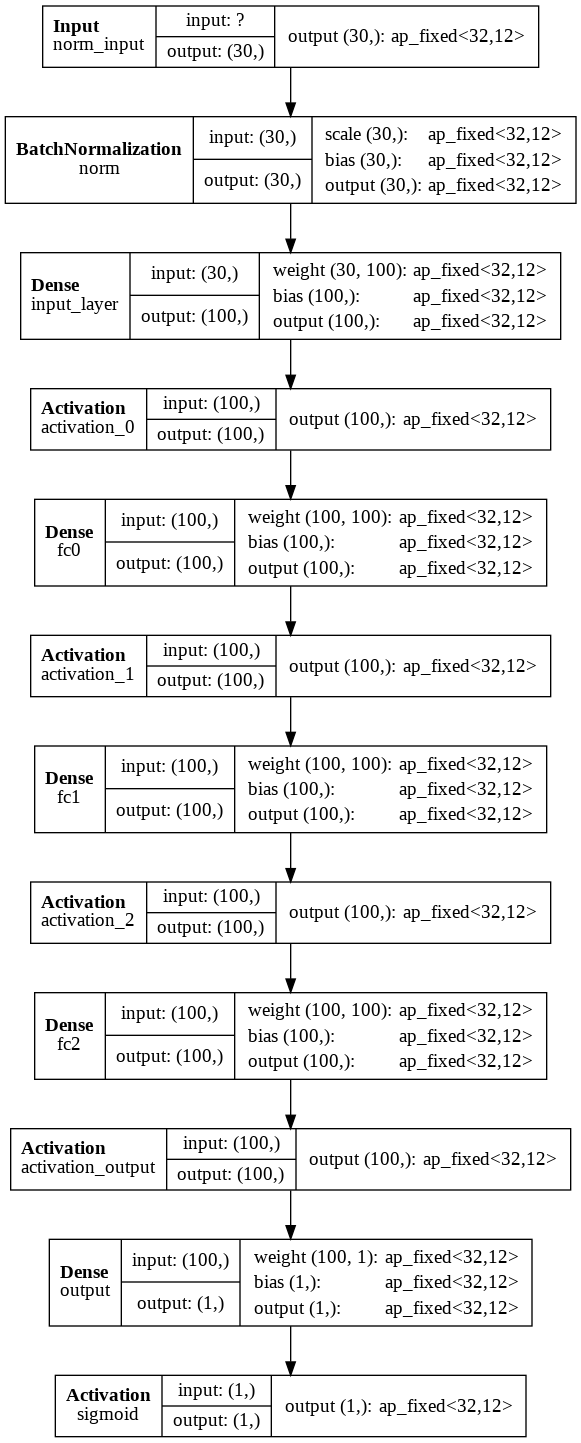

In [ ]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
""" 
Compile the hls model
""" 
hls_model.compile()


Writing HLS project
Done


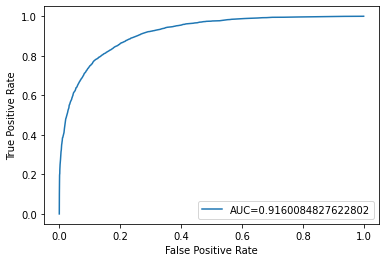

In [ ]:
""" 
make the ROC cure. Note that X for hls model needs to be in 
"ascontiguousarray" format first
""" 
X_hls_test = np.ascontiguousarray(X_test)
fpr, tpr, _ = metrics.roc_curve(Y_test, hls_model.predict(X_hls_test))
auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Post Training Quantization (PTQ)

In [ ]:
"""
Parameter search over integer bits. Fractional bits frozen at 20    
"""
fract_bit = 20
aurocs_int = []
ap_fixed_configs_int = []

for int_bit in range(10,15,1):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_keras_model(model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e'
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_int.append(auc)
    ap_fixed_configs_int.append(f"<{total_bit},{int_bit}>")
    


Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

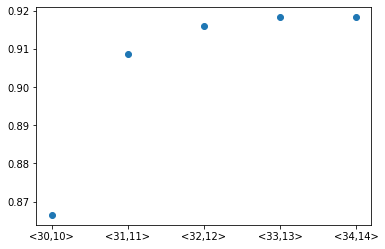

In [ ]:
plt.scatter(ap_fixed_configs_int, aurocs_int)

Looks like we don't lose performance until integer bit width = 13.

In [ ]:
"""
Parameter search over fractional bits. Integer bits frozen at 14    
"""
int_bit = 14
aurocs_fract = []
ap_fixed_configs_fract = []

for fract_bit in range(8,13,1):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_keras_model(model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e'
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_fract.append(auc)
    ap_fixed_configs_fract.append(f"<{total_bit},{int_bit}>")
    


Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

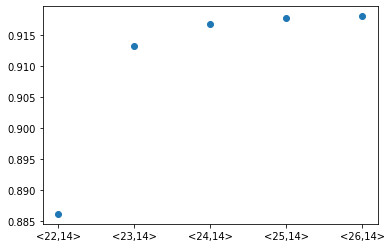

In [ ]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract)

## Quantization Aware Training + Pruning

AutoQKeras code based on https://github.com/google/qkeras/blob/master/notebook/

In [ ]:
""" 
setup for AutoQKeras.
"""

import json
import pprint
import numpy as np
import tempfile
from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

reference_internal = "fp32"
reference_accumulator = "fp32"

q = run_qtools.QTools(
    model,
    # energy calculation using a given process
    # "horowitz" refers to 45nm process published at
    # M. Horowitz, "1.1 Computing's energy problem (and what we can do about
    # it), "2014 IEEE International Solid-State Circuits Conference Digest of
    # Technical Papers (ISSCC), San Francisco, CA, 2014, pp. 10-14, 
    # doi: 10.1109/ISSCC.2014.6757323.
    process="horowitz",
    # quantizers for model input
    source_quantizers=[quantized_bits(8, 0, 1)],
    is_inference=False,
    # absolute path (including filename) of the model weights
    # in the future, we will attempt to optimize the power model
    # by using weight information, although it can be used to further
    # optimize QBatchNormalization.
    weights_path=None,
    # keras_quantizer to quantize weight/bias in un-quantized keras layers
    keras_quantizer=reference_internal,
    # keras_quantizer to quantize MAC in un-quantized keras layers
    keras_accumulator=reference_accumulator,
    # whether calculate baseline energy
    for_reference=True)
  
# caculate energy of the derived data type map.
energy_dict = q.pe(
    # whether to store parameters in dram, sram, or fixed
    weights_on_memory="sram",
    # store activations in dram or sram
    activations_on_memory="sram",
    # minimum sram size in number of bits. Let's assume a 16MB SRAM.
    min_sram_size=8*16*1024*1024,
    # whether load data from dram to sram (consider sram as a cache
    # for dram. If false, we will assume data will be already in SRAM
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(
    qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(
    qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()
print("Total energy: {:.2f} uJ".format(total_energy / 1000000.0))

Instructions for updating:
Use ref() instead.


{'activation_0': {'energy': {'inputs': 190.19,
                             'op_cost': 0.0,
                             'outputs': 190.19,
                             'parameters': 0.0},
                  'total': 190.19},
 'activation_1': {'energy': {'inputs': 190.19,
                             'op_cost': 0.0,
                             'outputs': 190.19,
                             'parameters': 0.0},
                  'total': 190.19},
 'activation_2': {'energy': {'inputs': 190.19,
                             'op_cost': 0.0,
                             'outputs': 190.19,
                             'parameters': 0.0},
                  'total': 190.19},
 'activation_output': {'energy': {'inputs': 190.19,
                                  'op_cost': 0.0,
                                  'outputs': 190.19,
                                  'parameters': 0.0},
                       'total': 190.19},
 'fc0': {'energy': {'inputs': 190.19,
                    'op_cost': 46000.

In [ ]:
"""
List of configs for AutoQKeras 
"""
quantization_config = {
        "kernel": {
                "binary": 1,
                "stochastic_binary": 1,
                "ternary": 2,
                "stochastic_ternary": 2,
                "quantized_bits(2,1,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
                "quantized_po2(4,1)": 4
        },
        "bias": {
                "quantized_bits(4,0,1)": 4,
                "quantized_bits(8,3,1)": 8,
                "quantized_po2(4,8)": 4
        },
        "activation": {
                "binary": 1,
                "ternary": 2,
                "quantized_relu_po2(4,4)": 4,
                "quantized_relu(3,1)": 3,
                "quantized_relu(4,2)": 4,
                "quantized_relu(8,2)": 8,
                "quantized_relu(8,4)": 8,
                "quantized_relu(16,8)": 16
        },
        "linear": {
                "binary": 1,
                "ternary": 2,
                "quantized_bits(4,1)": 4,
                "quantized_bits(8,2)": 8,
                "quantized_bits(16,10)": 16
        }
}

limit = {
    "Dense": [8, 8, 4],
    "Activation": [4],
    "BatchNormalization": []
}
goal = {
    "type": "energy",
    "params": {
        "delta_p": 8.0,
        "delta_n": 8.0,
        "rate": 2.0,
        "stress": 1.0,
        "process": "horowitz",
        "parameters_on_memory": ["sram", "sram"],
        "activations_on_memory": ["sram", "sram"],
        "rd_wr_on_io": [False, False],
        "min_sram_size": [0, 0],
        "source_quantizers": ["int8"],
        "reference_internal": "int8",
        "reference_accumulator": "int32"
        }
}


run_config = {
  "output_dir": tempfile.mkdtemp(),
  "goal": goal,
  "quantization_config": quantization_config,
  "learning_rate_optimizer": False,
  "transfer_weights": False,
  "mode": "random",
  "seed": 42,
  "limit": limit,
  "tune_filters": "layer",
  "tune_filters_exceptions": "^dense",
  # "distribution_strategy": cur_strategy,
  # first layer is input, layer two layers are softmax and flatten
  "layer_indexes": range(1, len(model.layers) - 1),
  "max_trials": 3
}

print("quantizing layers:", [model.layers[i].name for i in run_config["layer_indexes"]])

quantizing layers: ['input_layer', 'activation_0', 'fc0', 'activation_1', 'fc1', 'activation_2', 'fc2', 'activation_output', 'output']


In [ ]:
"""
apply AutoQKeras and fine tune your model.
"""
custom_objects = {}
autoqk = AutoQKeras(model, metrics=["acc"], custom_objects=custom_objects, **run_config)
autoqk.fit(X_train, Y_train, validation_split=0.20, batch_size=128, epochs=1, verbose=0) # 20

Limit configuration:{"Dense": [8, 8, 4], "Activation": [4], "BatchNormalization": []}
learning_rate: 0.0010000000474974513
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 norm (BatchNormalization)   (None, 30)                120       
                                                                 
 input_layer (QDense)        (None, 100)               3100      
                                                                 
 activation_0 (QActivation)  (None, 100)               0         
                                                                 
 fc0 (QDense)                (None, 100)               10100     
                                                                 
 activation_1 (QActivation)  (None, 100)               0         
                                                                 
 fc1 (QDense)                (None, 100)               10100     

In [ ]:
qmodel = autoqk.get_best_model()


learning_rate: 0.0010000000474974513
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 norm (BatchNormalization)   (None, 30)                120       
                                                                 
 input_layer (QDense)        (None, 50)                1550      
                                                                 
 activation_0 (QActivation)  (None, 50)                0         
                                                                 
 fc0 (QDense)                (None, 50)                2550      
                                                                 
 activation_1 (QActivation)  (None, 50)                0         
                                                                 
 fc1 (QDense)                (None, 50)                2550      
                                                                 
 activation_2 (QAct

The code above should give out a report, showing how much more light weight the function made your model to be.

To verify it ourselves, let's print the total number of trainable parameters for our model vs their qmodel.

In [ ]:
import tensorflow.keras.backend as K

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
print(f"model number of trainable parameters: {trainable_count}")
trainable_count = np.sum([K.count_params(w) for w in qmodel.trainable_weights])
print(f"qmodel number of trainable parameters: {trainable_count}")

model number of trainable parameters: 33561
qmodel number of trainable parameters: 14511


In [ ]:
""" 
need to train it all over again
""" 
adam = Adam(lr=0.001)
qmodel.compile(optimizer=adam, loss=['binary_crossentropy'])

qmodel.fit(X_train, Y_train, batch_size=64,
            epochs=30, validation_split=0.20, shuffle=True, verbose=0
) # fit makes batchnorm to be in training mode

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Part 2: Plot the ROC curve for qmodel, like we have done so with our normal model**

426/426 [==============================] - 2s 4ms/step


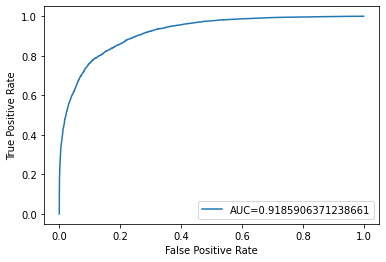

In [ ]:
X_hls_test = np.ascontiguousarray(X_test)
fpr, tpr, _ = metrics.roc_curve(Y_test, qmodel.predict(X_hls_test))
auc = metrics.roc_auc_score(Y_test, qmodel.predict(X_hls_test))
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Printing the model's summary and find the difference with the former model.

Manually define a new model that fits qmodel's parameters, and load the trained qmodel weights into it.

In [ ]:
qmodel.predict(X_test, verbose = 0)
print(qmodel.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 norm (BatchNormalization)   (None, 30)                120       
                                                                 
 input_layer (QDense)        (None, 50)                1550      
                                                                 
 activation_0 (QActivation)  (None, 50)                0         
                                                                 
 fc0 (QDense)                (None, 50)                2550      
                                                                 
 activation_1 (QActivation)  (None, 50)                0         
                                                                 
 fc1 (QDense)                (None, 50)                2550      
                                                                 
 activation_2 (QActivation)  (None, 50)               

In [ ]:
qmodel.weights;

**Part 3: Using the output of the model summary, write new code that defines a keras tensorflow model with the matching parameters and define that new model as "new_model" in your code.**

In [ ]:
input_dim = X_train.shape[-1]
hidden_dim = 100
n_hidden_layers = 2

new_model = Sequential()
new_model.add(BatchNormalization(input_shape=(input_dim,), name='norm'))
new_model.add(Dense(50, name='input_layer', kernel_regularizer=l2(0.0001)))

for idx in range(n_hidden_layers): # hidden layers
    new_model.add(Activation(activation="relu", name=f'activation_{idx}'))
    new_model.add(Dense(50, name=f'fc{idx}', kernel_regularizer=l2(0.0001)))

new_model.add(Activation(activation="relu", name=f'activation_{2}'))    
new_model.add(Dense(150, name=f'fc{2}', kernel_regularizer=l2(0.0001)))

new_model.add(Activation(activation="relu", name=f'activation_output'))
new_model.add(Dense(1, name='output', kernel_regularizer=l2(0.0001)))

new_model.add(Activation(activation='sigmoid', name='sigmoid'))

In [ ]:
print(new_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 norm (BatchNormalization)   (None, 30)                120       
                                                                 
 input_layer (Dense)         (None, 50)                1550      
                                                                 
 activation_0 (Activation)   (None, 50)                0         
                                                                 
 fc0 (Dense)                 (None, 50)                2550      
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 fc1 (Dense)                 (None, 50)                2550      
                                                                 
 activation_2 (Activation)   (None, 50)               

Load the saved qmodel weights and do the bitwidth searches again.

In [ ]:
# new_model.load_weights("qmodel.h5")
new_model.set_weights(qmodel.weights)

**Part 4: Take the new model and do the same PTQ as we did in the previous cells. Plot the integer bitwidth and fractional bitwidth for original model and qmodel together and compare any differences.**

In [ ]:
"""
Parameter search over integer bits. Fractional bits frozen at 20    
"""
fract_bit = 20
aurocs_int = []
ap_fixed_configs_int = []

for int_bit in range(10,15,1):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_keras_model(new_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    hls_model = hls4ml.converters.convert_from_keras_model(new_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e'
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_int.append(auc)
    ap_fixed_configs_int.append(f"<{total_bit},{int_bit}>")
    


Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

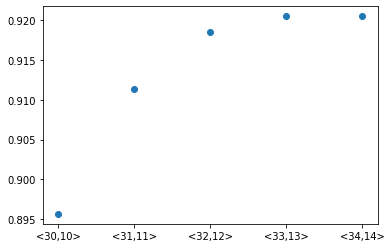

In [ ]:
plt.scatter(ap_fixed_configs_int, aurocs_int)

# The above result looks similar to the original model, integer bits = 14 looks good

In [ ]:
"""
Parameter search over fractional bits. Integer bits frozen at 14    
"""
int_bit = 14
aurocs_fract = []
ap_fixed_configs_fract = []

for fract_bit in range(8,13,1):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_keras_model(new_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    hls_model = hls4ml.converters.convert_from_keras_model(new_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e'
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_fract.append(auc)
    ap_fixed_configs_fract.append(f"<{total_bit},{int_bit}>")

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

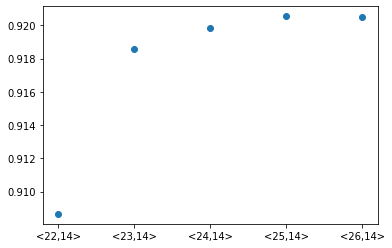

In [ ]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract)

# The above result looks similar to the original model, fractional bits = 10 looks good